In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import mplfinance as mpf
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
import joblib as jb

### LAY MA CO PHIEU ###

In [27]:
df = yf.Ticker("AAPL")

pd.set_option('display.max_rows', None)

df_data = df.history(period="max")
df_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11055 entries, 1980-12-12 00:00:00-05:00 to 2024-10-18 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11055 non-null  float64
 1   High          11055 non-null  float64
 2   Low           11055 non-null  float64
 3   Close         11055 non-null  float64
 4   Volume        11055 non-null  int64  
 5   Dividends     11055 non-null  float64
 6   Stock Splits  11055 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 690.9 KB


In [28]:
for key, value in df.info.items():
    print(key, ":", value)

address1 : One Apple Park Way
city : Cupertino
state : CA
zip : 95014
country : United States
phone : 408 996 1010
website : https://www.apple.com
industry : Consumer Electronics
industryKey : consumer-electronics
industryDisp : Consumer Electronics
sector : Technology
sectorKey : technology
sectorDisp : Technology
longBusinessSummary : Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as App

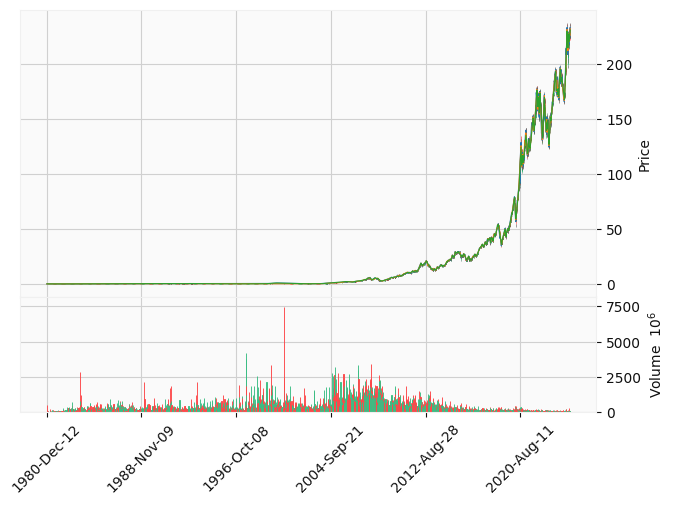

In [29]:
# draw general candle plots
mpf.plot(df_data, type = 'candle', volume =True, style = 'yahoo', mav = (3,6,9))


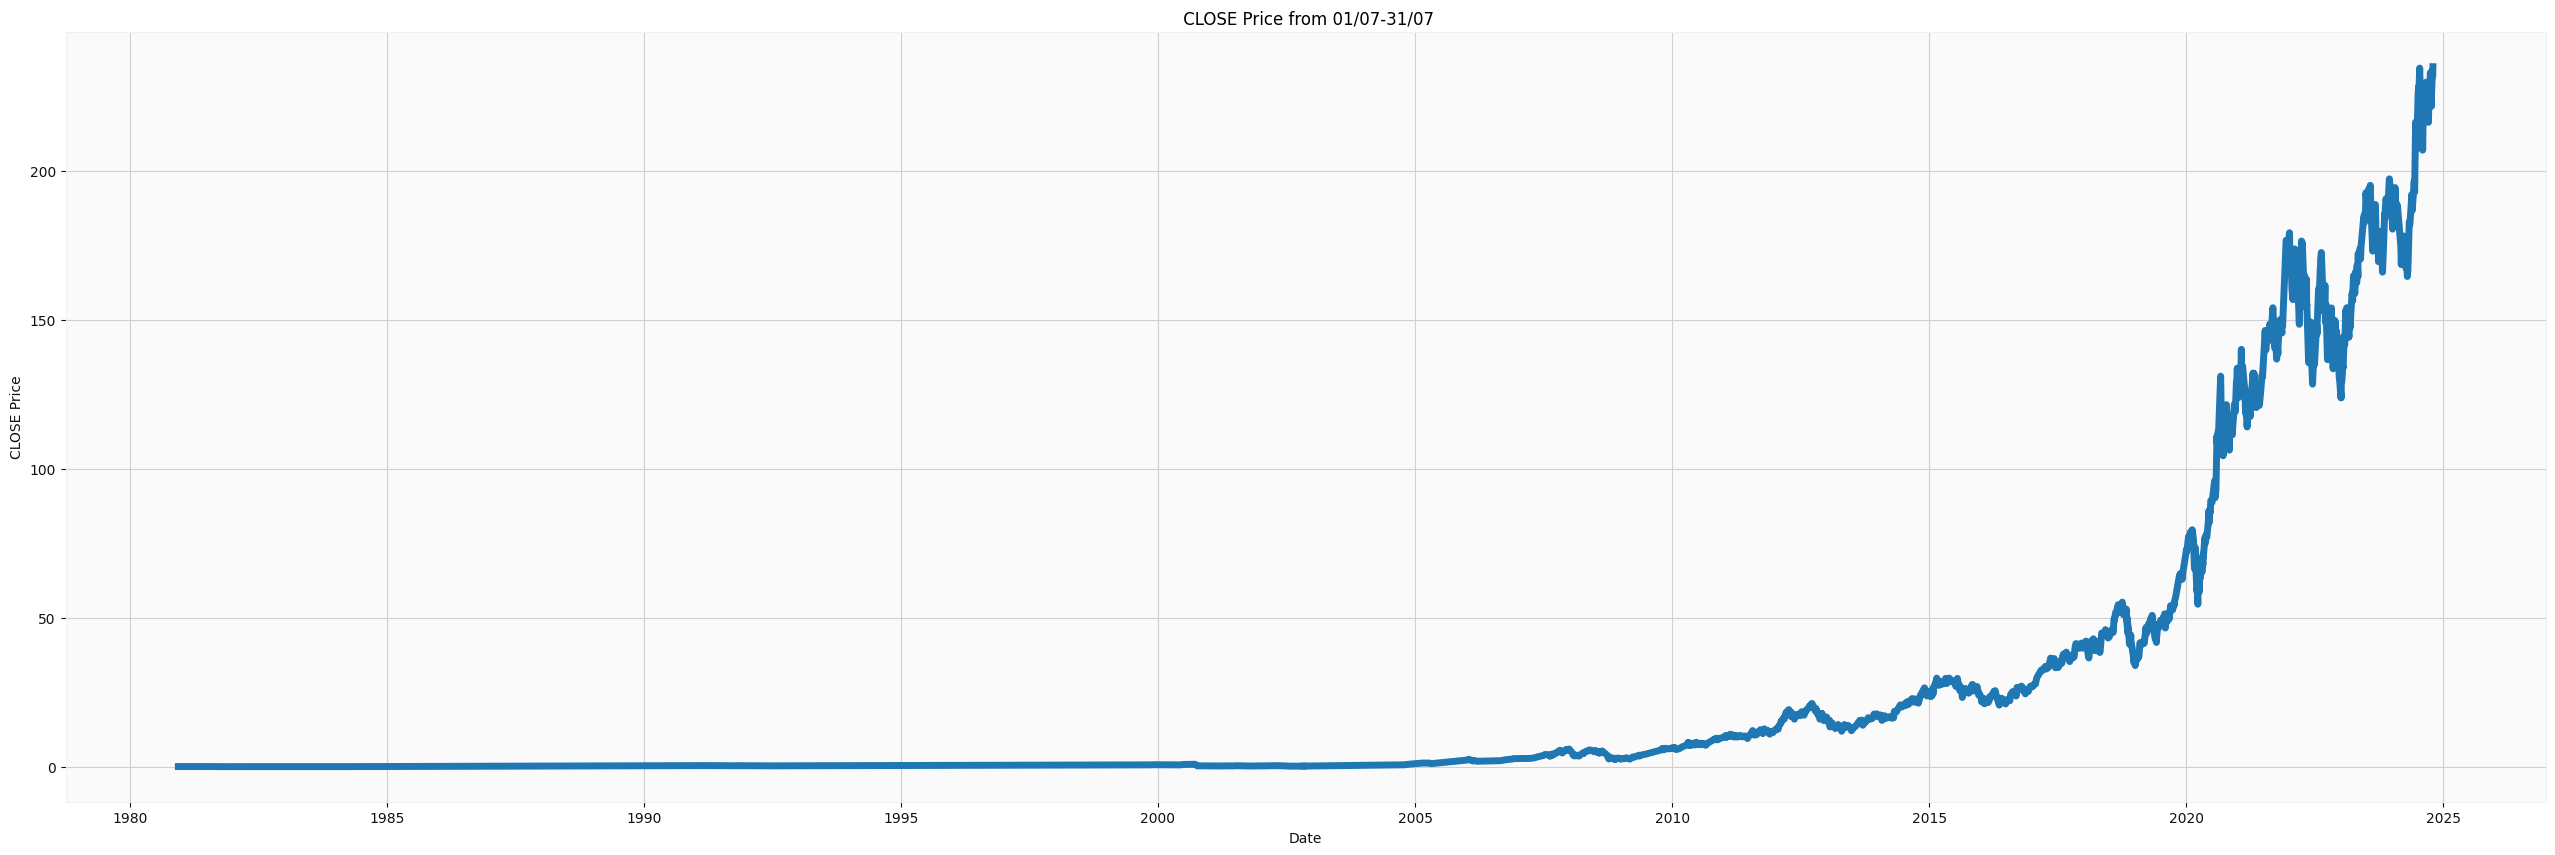

In [30]:
# draw line chart using seaborn
fig, ax = plt.subplots(figsize=(32, 10), dpi=100)
ax.set_title(" CLOSE Price from 01/07-31/07")
ax.set_xlabel("Date")
ax.set_ylabel("CLOSE Price")
sns.lineplot(data=df_data["Close"], palette= ['red'], linewidth=5, legend=True )
plt.show()


### ***BUILD MODEL***

In [31]:
X = df_data.values
y = df_data['Close']

In [32]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(y.values.reshape(-1,1)) 


In [33]:
import math

In [34]:
dataset = y.values

In [35]:
training_data_len  = math.ceil(len(dataset)*.8)
training_data_len

8844

In [36]:
prediction_days = 60
future = 30
# give detail of the chart (split data into x_train, y_train) 
x_train = []
y_train =[]

for i in range(prediction_days, len(scaled_data)-future):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i+future,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [38]:
# create model LSTM
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0,2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0,2))
model.add(LSTM(units = 50))
model.add(Dropout(0,2))
model.add(Dense(units = 1))
#compiling and training 
model.compile(optimizer = 'adam', loss ='mean_squared_error')
# epochs: How many times the data is trained in network
# batch_size: The number of training samples in the network at once 
model.fit(x_train, y_train, epochs  = 1, batch_size = 1)

10965/10965 ━━━━━━━━━━━━━━━━━━━━ 264s 24ms/step - loss: 0.0024


In [39]:
test_data = scaled_data[training_data_len - prediction_days: , :]

In [40]:
X_test = []
y_test = scaled_data[training_data_len:,:]
for i in range(prediction_days, len(test_data)):
    X_test.append(test_data[i-prediction_days:i,0])

In [41]:
X_test = np.array(X_test)

In [42]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [43]:
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### ***RESULT***

In [44]:
train = df_data[:training_data_len]
valid = df_data[training_data_len:]
valid['Prediction'] = predicted_price

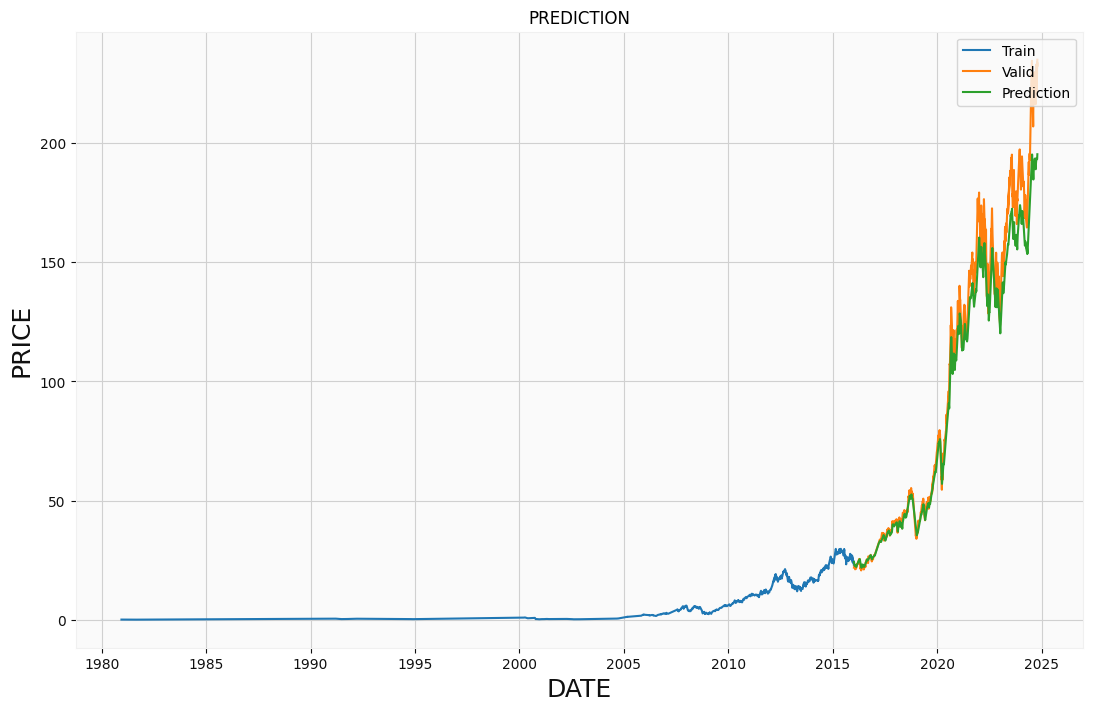

In [45]:
plt.figure(figsize = (13,8))
plt.title('PREDICTION')
plt.xlabel('DATE', fontsize  = 18)
plt.ylabel('PRICE',fontsize  = 18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Prediction'])
plt.legend(['Train', 'Valid', 'Prediction'], loc = 'upper right')
plt.show()



In [46]:
result = valid[['Close','Prediction']]
result

,Close,Prediction
Date,,
2016-01-07 00:00:00-05:00,21.868868,24.264450
2016-01-08 00:00:00-05:00,21.984501,23.909803
2016-01-11 00:00:00-05:00,22.340479,23.533548
2016-01-12 00:00:00-05:00,22.664719,23.248072
2016-01-13 00:00:00-05:00,22.082001,23.108671
2016-01-14 00:00:00-05:00,22.564951,23.023369
2016-01-15 00:00:00-05:00,22.023052,23.000746
2016-01-19 00:00:00-05:00,21.916479,22.965054
2016-01-20 00:00:00-05:00,21.945957,22.893202


In [47]:
# check acuracy 
def Accuracy_result(actual_price, prediction):
    result = np.mean(100 * (np.abs(actual_price - prediction) / prediction))
    return(100-result)
print("The accuracy for this model is", str(Accuracy_result(valid['Close'][0],predicted_price[0])), "%")

The accuracy for this model is 90.12719345092773 %


In [48]:
jb.dump(model,'model.pkl')
jb.dump(scaler,'scaler.pkl')

['scaler.pkl']